In [16]:
from alpha.notebook import *
from alpha.core.rsi_stats import rsiday, rsi30
from omicron.core.numpy_extensions import find_runs
await init_notebook()
from IPython.display import display
import asyncio
pd.options.display.max_rows = 999

In [14]:
def cut_runs(ts):
    value, start_pos, length = find_runs(ts)
    if len(value) < 2:
        return None, None
    
    return value[-2:], length[-2:]

def uturn(code, name, bars, results, frame_type):
    close = bars["close"]
    
    if len(bars) < 20:
        return
    
    # 要求最近一日站在5日线上
    if close[-1] < np.mean(close[-5:]):
        return

    # 探测反转
    prices = bars["open"] + bars["close"]
    flags, lengths = cut_runs((prices[1:]>=prices[:-1])[-10:])
    if flags is None or flags[0]:
        return
    
    ll, rl = lengths
    pos = rl

    # 涨速
    dv = close[1:] / close[:-1]
    ddv = moving_average(dv[1:] - dv[:-1], 3)[-1]
    ddv = round(ddv, 2)
    
    if ddv < 1e-3:
        return
    
    # rsi
    rsi = relative_strength_index(close)[-1]
    stats = rsiday if frame_type == FrameType.DAY else rsi30
    prsi = stats.get_proba(code, rsi)

    results.append([name, code, ddv, rl, prsi, rsi])

In [6]:
results = await scan(uturn, 20, tm="2021-10-26", test=False)
df = pd.DataFrame(results, columns=["name", "code", "ddv", "bottom", "prsi", "rsi"])

progress: 500/3992, elapsed: 50, ETA: 349
progress: 1000/3992, elapsed: 99, ETA: 296
progress: 1500/3992, elapsed: 151, ETA: 250
progress: 2000/3992, elapsed: 178, ETA: 177
progress: 2500/3992, elapsed: 223, ETA: 133
progress: 3000/3992, elapsed: 271, ETA: 89
progress: 3500/3992, elapsed: 298, ETA: 41


In [ ]:
async def wait(results:List, check_now=True):
    # 补齐前两天的rsi和prsi并显示
    end = tf.floor(arrow.now(), FrameType.DAY)
    start = tf.day_shift(end, -39)
    codes = []
    for item in results:
        name, code, ddv, skew, msr = item
        codes.append(code)
        
        sec = Security(code)
        bars = await sec.load_bars(start, end, FrameType.DAY)
        bars = bars[np.isfinite(bars["close"])]
        
        close = bars["close"]
        rsi = np.round(relative_strength_index(close, 6)[-2:], 1)
        prsi = [rsiday.get_proba(code, r) for r in rsi]
        
        item.extend([*rsi, *prsi])
        
    df = pd.DataFrame(results,columns = ["name", "code", "ddv", "skew", "msr", "rsi1", "rsi0", "prsi1", "prsi0"])
    
    print("对以下列表进行监控:")
    display(df)
    
    now = arrow.now()
    wakeup_time = []
    for tm in ["09:59", "10:29", "10:59", "11:29", "13:29", "13:59", "14:29", "14:56"]:
        hour, minute = map(int, tm.split(":"))
        wakeup_time.append(arrow.Arrow(now.year, now.month, now.day, hour, minute, tzinfo="Asia/Shanghai"))
        
    if check_now:
        wakeup_time.insert(0, arrow.now().shift(seconds=5))
    
    for tm in wakeup_time:
        if arrow.now() > tm:
            continue
            
        seconds = (tm.timestamp - arrow.now().timestamp)
        await asyncio.sleep(seconds)
        
        for code in codes:
            sec = Security(code)
            end = arrow.now().datetime
            start = tf.shift(tf.floor(end, FrameType.MIN30), -30, FrameType.MIN30)
            
            try:
                bars = await sec.load_bars(start, end, FrameType.MIN30)
            except Exception:
                continue
            bars = bars[np.isfinite(bars["close"])]
            close = bars["close"]
            
            rsi = relative_strength_index(close, 6)[-1]
            prsi = rsi30.get_proba(code, rsi)
            if (prsi and prsi < 0.1) or rsi < 20:
                text = f"{sec.display_name}出现RSI低位,概率为{prsi}[RSI:{rsi}]"
                print(text)
                say(text)
                
async def scan_and_wait():
    tm = tf.day_shift(arrow.now(),0)
    results = await scan(uturn, 20, tm="2021-10-26", test=True)
    await wait(results)
    
await scan_and_wait()

In [ ]:
async def ddv(code, tm=None):
    if code.startswith("6"):
        code += ".XSHG"
    else:
        code += ".XSHE"
        
    sec = Security(code)
    end = arrow.get(tm).date() if tm else arrow.now().date()
    start = tf.day_shift(end, -10)
    
    bars = await sec.load_bars(start, end, FrameType.DAY)
    close = bars["close"]
    
    d1 = close[1:]/close[:-1]
    d2 = np.diff(d1)
    return np.round(d1[-5:], 2), np.round(d2[-5:], 2)

In [ ]:
await ddv("300506")

In [ ]:
await scan("2021-10-26")

In [9]:
def u_turn(bars):
    n = len(bars)
    half = n // 2
    
    c = bars["close"]
    o = bars["open"]
    
    # 前半程以收阴为主，后半程全部收阳
    flag = bars["close"] > bars["open"]
    if np.all(flag[-half:]) and np.all(~flag[:(n-half)]):
        if c[-1] > c[0]:
            return 'U'
    
    # 后半程全部收阴，前半程收阳为主
    if np.all(~flag[-half:]) and np.all(flag[:(n-half)]):
        if c[-1] < c[0]:
            return '^'
        
    return ""

In [19]:
sh = jq_get_bars("000001.XSHG", 10, '30m')

In [20]:
cut_runs(sh["close"]<sh["open"])

(array([False,  True]), array([1, 3]))

In [23]:
close = sh["close"]
roc = close[1:]>close[:-1]
cut_runs(roc)

(array([ True, False]), array([1, 3]))

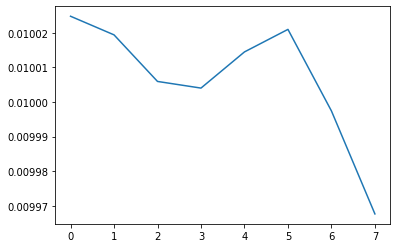

In [41]:
price = sh["open"] + sh["close"]
plt.plot((price*0.01/price[0])[2:])

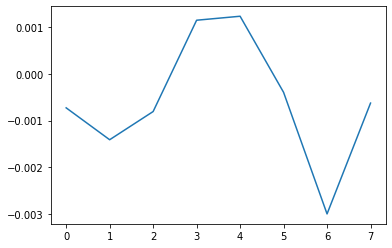

In [42]:
plt.plot(np.diff(price[1:]/price[:-1]))

In [46]:
def local_extremum(data):
    min_max = np.diff(np.sign(np.diff(data))).nonzero()[0] + 1          # local min & max
    l_min = (np.diff(np.sign(np.diff(data))) > 0).nonzero()[0] + 1      # local min
    l_max = (np.diff(np.sign(np.diff(data))) < 0).nonzero()[0] + 1      # local max
    
    return l_max, l_min

In [58]:
def double_top_bottom(bars, neck_height=2e-3, thres=5e-4):
    prices = (bars["close"] + bars["open"])/2
    ddv = np.diff(prices[1:]/prices[:-1])
    # this will involves movement of 5 bars
    ma_ddv = moving_average(ddv, 2)
    
    l_max, l_min = local_extremum(prices)
    # calc distance between neck and top/bottom
    d = max(prices[l_max]) / min(prices[l_min]) - 1
    print(d)
    if d < neck_height:
        return None
    
    if len(l_max) == 2:
        max1, max2 = prices[l_max]
        min1 = prices[l_min][0]
        print(abs(max1/max2-1))
        if abs(max1/max2-1) < thres and prices[-1] < min1:
            return 'M'
    
    if len(l_min) == 2:
        min1, min2 = prices[l_min]
        max1 = prices[l_max[0]]
        
        print(abs(min1/min2-1))
        if abs(min1/min2-1) < thres and prices[-1] > max1:
            return 'W'
        
    return None
        
double_top_bottom(sh)

0.002073222846069589
0.0003786878062019827


'M'

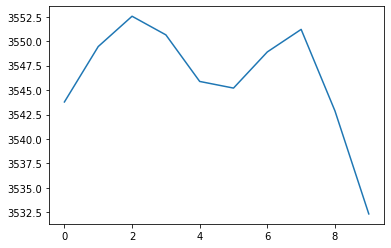

In [48]:
prices = (sh["open"] + sh["close"])/2
plt.plot(prices)

bars: 10, ma: 6, d2: 4


(-0.001689836174456727,
 [{'buy': 3554.4274,
   'buy_at': datetime.datetime(2021, 11, 2, 10, 0),
   'sell': 3548.421,
   'sell_at': datetime.datetime(2021, 11, 2, 10, 30),
   'gain': 0.9983101638255433}])

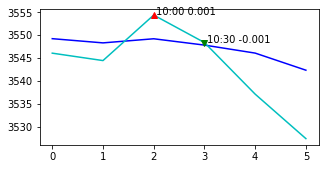

In [278]:
def ddv(bars, thres=3e-4):
    w = len(bars) / 2
    h = w / 2
    plt.figure(figsize=(w, h))
    ma = moving_average(bars["close"], 5)
    
    d1 = ma[1:]/ma[:-1]
    d2 = np.diff(d1)
    
    print(f"bars: {len(bars)}, ma: {len(ma)}, d2: {len(d2)}")
    
    isup, pos, length = find_runs(d2 >0)
        
    # 只保留变化显著的那些点
    valid_pos = pos[abs(d2[pos]) > thres]
    isup = isup[abs(d2[pos]) > thres]
    pos = valid_pos
    
    plt.plot(ma, color='b')
    close = bars["close"][4:]
    plt.plot(close, color='c')
    
    # convert d2 pos to ma pos
    pos += 2
    
    up = pos[isup]
    down = pos[~isup]

    plt.plot(up, close[up], 'r^')
    plt.plot(down, close[down], 'gv')
    
    for x in pos:
        tm = str(bars["frame"][x+4]).split(" ")
        if len(tm) == 2: # it's time
            tm = tm[1][:-3]
        else:
            tm = tm[0][-5:]
            
        plt.text(x+0.05, close[x], f"{tm} {d2[x-2]:.03f}")
        
    trades = []
    gains = 1
    order = None
    
    for f, p in zip(isup, pos):
        # convert ma position to bars' position
        p += 4
        if f and order is None:
            order = {
                "buy": bars["close"][p],
                "buy_at": bars["frame"][p]
            }
            
        elif (not f) and order:
            buy = order["buy"]
            sell = bars["close"][p]
            gain = sell / buy
            order.update({
                "sell": sell,
                "sell_at": bars["frame"][p],
                "gain": gain
            })
            
            gains *= gain
            trades.append(order)
            order = None
            
    return gains - 1, trades
    
ddv(sh)

bars: 30, ma: 26, d2: 24


(0.03401326209321698,
 [{'buy': 3485.29,
   'buy_at': datetime.date(2021, 8, 18),
   'sell': 3528.15,
   'sell_at': datetime.date(2021, 8, 30),
   'gain': 1.012297398494817},
  {'buy': 3597.04,
   'buy_at': datetime.date(2021, 9, 2),
   'sell': 3581.73,
   'sell_at': datetime.date(2021, 9, 3),
   'gain': 0.9957437226163735},
  {'buy': 3621.86,
   'buy_at': datetime.date(2021, 9, 6),
   'sell': 3715.37,
   'sell_at': datetime.date(2021, 9, 13),
   'gain': 1.0258182259943784}])

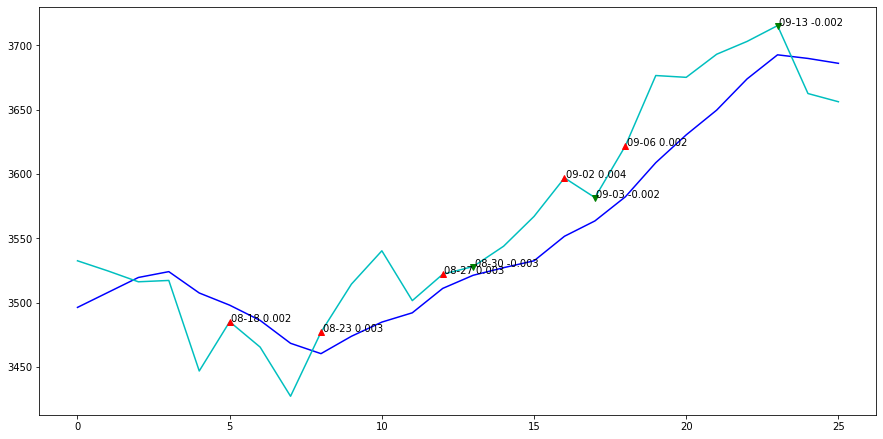

In [284]:
shday = jq_get_bars("000001.XSHG", 30, '1d', '2021-09-15 15:00')
shday['frame'][-1]
ddv(shday, 1.5e-3)
# close = (shday["close"] + shday["open"])/2
# d1 = close[1:]/close[:-1] - 1
# d2 = np.diff(d1)
# d1 = np.insert(d1, 0, d1[0])
# d2 = np.insert(d2, 0, [d2[0]] * 2)

# # print(' '.join([str(d)[-7:] for d in shday["frame"]]))
# # print(np.round(d1,3))
# # print(np.round(d2,3))

# flag, pos, _ = find_runs(d2 > 0)
# print("拐点", pos)

# for f, p in zip(flag, pos):
#     print('买' if f else '卖', shday["frame"][p])

[-0.00307588  0.00198433 -0.01175328  0.01182782 -0.00481825]


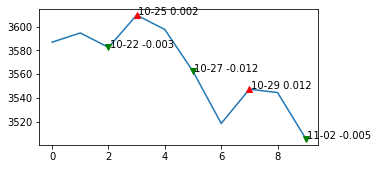

In [210]:
shday = jq_get_bars("000001.XSHG", 10, '1d', '2021-11-02 15:00')
shday['frame'][-1]
ddv(shday)

[-0.006  0.011 -0.011 -0.006 -0.003  0.021 -0.009 -0.01 ]


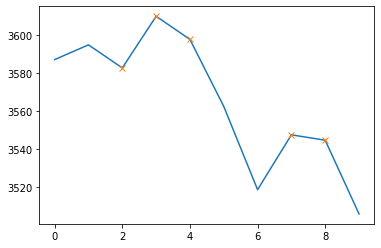

In [211]:
d2 = np.round(np.diff(shday['close'][1:]/shday['close'][:-1]),3)
print(d2)
flag, pos, length = find_runs(d2 > 0)
pos + 2

plt.plot(shday["close"])
plt.plot(pos + 2, shday["close"][pos+2], 'x')

bars: 60, ma: 56, d2: 54
拐点 [ 6  9 12 13 16 17 18 20 24 27 28 29 36 39 42 43 44 46 49 50 53 54 56 59]


-0.0

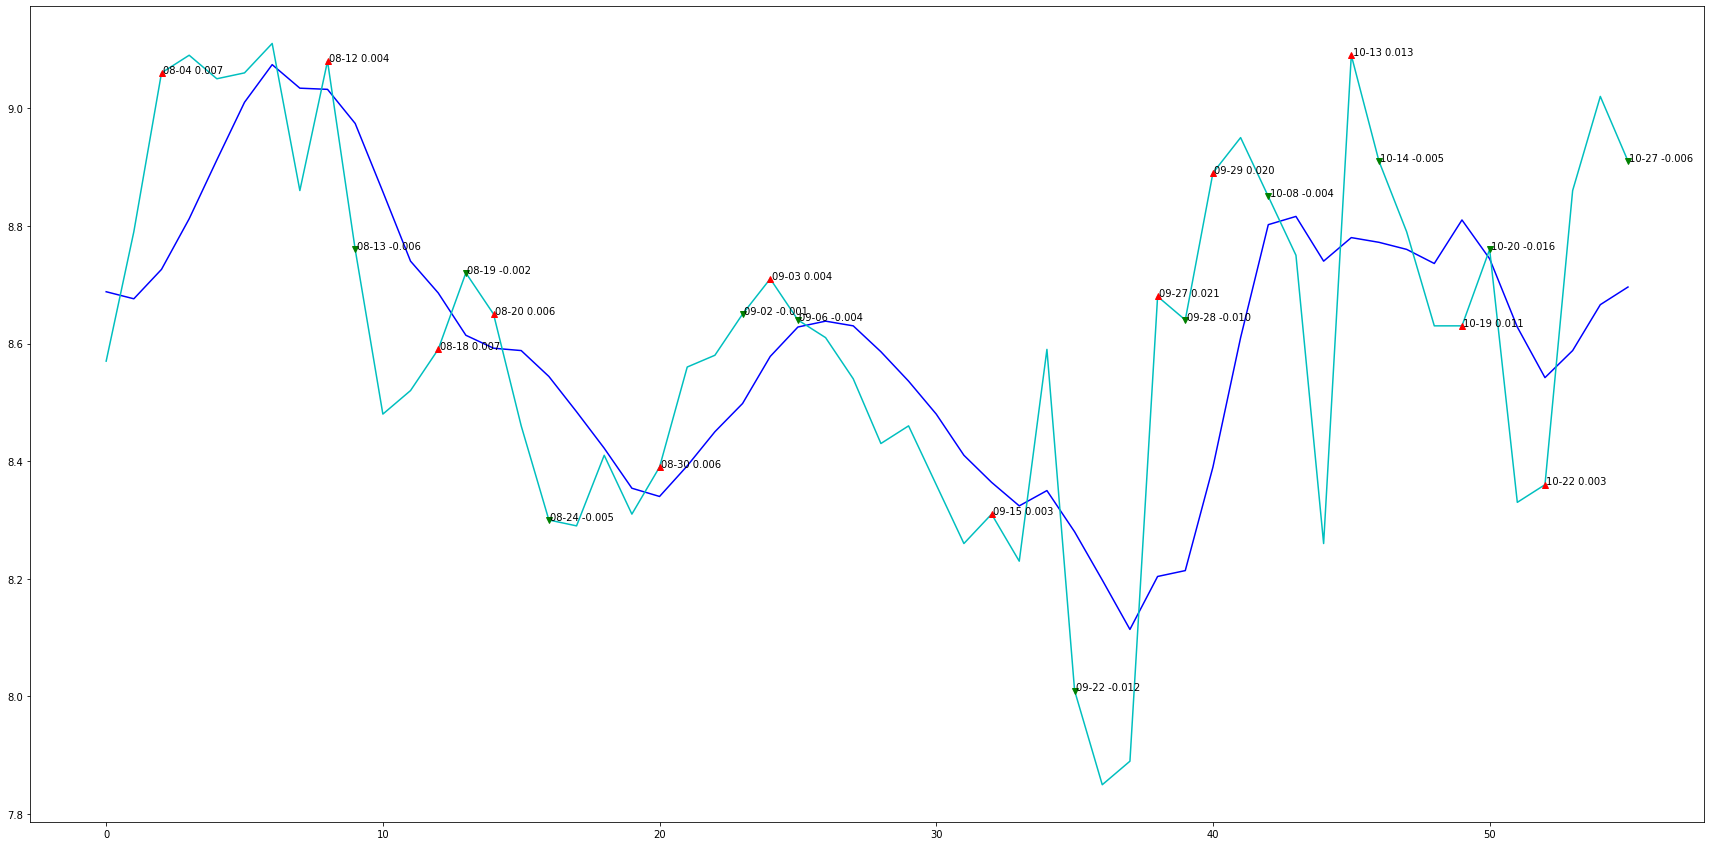

In [273]:
ddv(df, 1e-3)

In [323]:
df[-1]["close"]/df[0]["open"] - 1

0.08394160583941601